# TP2 - Reconnaissance de chiffres manuscrits par $k$ plus proches voisins

L'objectif de ce TP est de reconnaître des chiffres manuscrits d'une base de test à partir d'une base d'apprentissage et de la méthode des $k$ plus proches voisins. 
La base de données du MNIST{\footnote{http://yann.lecun.com/exdb/mnist/}} sur les chiffres manuscrits comprend un ensemble de 60 000 exemples d'apprentissage (*database_train_images*) et un ensemble de 10 000 exemples de test (*database_test_images*).  Les chiffres, dont quelques exemples sont représentés sur la figure ci-dessous, ont été normalisés et centrés dans une image de taille fixe $28\times 28$ pixels. 

<img src="files/MNIST.PNG" width="600" height="400"  >




Chaque image est considérée comme un vecteur 1D de $28\times 28=784$ coordonnées. On fournit les labels des ensembles d'apprentissage (*y_train*) et de test 
(*y_test*).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
import scipy as sc
from sklearn.metrics.pairwise import euclidean_distances

### Chargement de la base de données MNIST

Lien du dataset des chiffres manuscrits :
http://yann.lecun.com/exdb/mnist/

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784")

X, y = mnist["data"], mnist["target"]

Xa,Xt,Ya,Yt = X[:60000] , X[60000:] , y[:60000] , y[60000:]

print('DataApp: ' + str(Xa.shape))
print('LabelApp: ' + str(Xt.shape))
print('DataTest:  '  + str(Ya.shape))
print('LabelTest:  '  + str(Yt.shape))

# Conversion en matrices
Xa=np.asarray(Xa)
Xt=np.asarray(Xt)
Ya=np.asarray(Ya)
Yt=np.asarray(Yt)

DataApp: (60000, 784)
LabelApp: (10000, 784)
DataTest:  (60000,)
LabelTest:  (10000,)


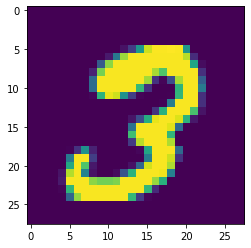

le label de cette image d'apprentissage est : 3


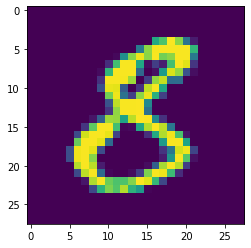

le label de cette image de test est : 8


In [3]:
# Affichage d'images de ce jeu de données : 

# on affiche une donnée image de X_train et X_test :
NumImageTrain=12345 # à choisir entre 0 et 59999
Exple1=Xa[NumImageTrain,:]
ImExple1=np.reshape(Exple1,[28,28])
plt.imshow(ImExple1)
plt.show()
print("le label de cette image d'apprentissage est :", Ya[NumImageTrain])

NumImageTest=1234 # à choisir entre 0 et 9999
Exple2=Xt[NumImageTest,:]
ImExple2=np.reshape(Exple2,[28,28])
plt.imshow(ImExple2)
plt.show()
print("le label de cette image de test est :", Yt[NumImageTest])

## Exercice 1 : méthode des $k$ plus proches voisins

En intelligence artificielle, la méthode des $k$ plus proches voisins  ($k$-ppv) est une méthode d'apprentissage supervisé. 
Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples « donnée-label ». Pour estimer la sortie associée à une nouvelle entrée $x$, la méthode des $k$ plus proches voisins consiste à prendre en compte (de façon identique) les $k$ échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle entrée $x$, selon une distance à définir. L'algorithme  associé  et un exemple sont donnés par la suite.



<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >


**Exemple de classification $k$-ppv:** L'échantillon de test (cercle vert) doit être classé soit dans la première classe des carrés bleus, soit dans la deuxième classe des triangles rouges. Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)

**Question :**
En utilisant la distance euclidienne, complétez la fonction *kppv* permettant d'effectuer la classification par $k$-ppv sur un ensemble de test à partir d'un ensemble d'apprentissage et de leurs labels et en spécifiant le nombre $k$  voisins que l'on cherche.  



### Fonctions python intéressantes : 
Liste de fonctions (librairies) :

- euclidean_distance (sklearn) 
- mode (scipy.stats) [à changer pour traiter le cas d'égalité]
- argsort (numpy)


In [36]:

def kppv(Xa,Xt,Ya,K,Nt=Xt.shape[0],Na=Xa.shape[0]):
    M_distances=euclidean_distances(Xt[:Nt,:],Xa[:Na,:]) # la distance de tous les points test avec ceux de Xa
    
    # Initialisation du vecteur d'etiquetage des images tests
    Partition = np.empty((Nt,1),dtype=str);

    # Boucle sur les vecteurs test de l'ensemble de l'evaluation
    for i in range(Nt):
               
        # Calcul des distances entre les vecteurs de test 
        # et les vecteurs d'apprentissage (voisins)
        distances=M_distances[i,:]
        # On ne garde que les indices des K + proches voisins
        i_voisins= np.argsort(distances)[:K]
        voisins= np.array([Ya[i] for i in i_voisins])
        
        # Comptage du nombre de voisins appartenant a chaque classe
        v,v_count=np.unique(voisins,return_counts=True)
        
        # Recherche de la classe contenant le maximum de voisins
        i_voisins_max=np.argsort(-v_count)
        
        # Si l'image test a le plus grand nombre de voisins dans plusieurs  
        # classes differentes, alors on lui assigne celle du voisin le + proche,
        # sinon on lui assigne l'unique classe contenant le plus de voisins 
        if len(v_count)>1 and v_count[i_voisins_max[0]]==v_count[i_voisins_max[1]]:
            predict=voisins[0] # le plus proche
        else:
            predict=v[i_voisins_max[0]]
        
        # Assignation de l'etiquette correspondant ‡ la classe trouvee au point 
        # correspondant a la i-eme image test dans le vecteur "Partition" 
        Partition[i][0]=predict
    

    return np.ravel(Partition)

In [37]:
# Choix du nombre de voisins
K = 10;

# Nombre de données à tester
Nt_test = 100; # A changer, pouvant aller jusqu'a Nt


# Classement par aux k-ppv
Partition = kppv(Xa,Xt,Ya,K,Nt_test);

# Affichage des résultats de prédiction et de vérité terrainMatriceConfusion=np.zeros((10,10))
print('Resultat Kppv',Partition)
print('Vérité terrain',Yt[:Nt_test])

Resultat Kppv ['7' '2' '1' '0' '4' '1' '4' '9' '5' '9' '0' '6' '9' '0' '1' '5' '9' '7'
 '3' '4' '9' '6' '6' '5' '4' '0' '7' '4' '0' '1' '3' '1' '3' '4' '7' '2'
 '7' '1' '2' '1' '1' '7' '4' '1' '3' '5' '1' '2' '4' '4' '6' '3' '5' '5'
 '6' '0' '4' '1' '9' '5' '7' '8' '9' '3' '7' '4' '6' '4' '3' '0' '7' '0'
 '2' '9' '1' '7' '3' '7' '9' '7' '7' '6' '2' '7' '8' '4' '7' '3' '6' '1'
 '3' '6' '9' '3' '1' '4' '1' '7' '6' '9']
Vérité terrain ['7' '2' '1' '0' '4' '1' '4' '9' '5' '9' '0' '6' '9' '0' '1' '5' '9' '7'
 '3' '4' '9' '6' '6' '5' '4' '0' '7' '4' '0' '1' '3' '1' '3' '4' '7' '2'
 '7' '1' '2' '1' '1' '7' '4' '2' '3' '5' '1' '2' '4' '4' '6' '3' '5' '5'
 '6' '0' '4' '1' '9' '5' '7' '8' '9' '3' '7' '4' '6' '4' '3' '0' '7' '0'
 '2' '9' '1' '7' '3' '2' '9' '7' '7' '6' '2' '7' '8' '4' '7' '3' '6' '1'
 '3' '6' '9' '3' '1' '4' '1' '7' '6' '9']


## Exercice 2 : évaluation de la reconnaissance

En disposant des labels exacts des données de l'ensemble de test, l'évaluation de la bonne reconnaissance est réalisée par une matrice de confusion et par un taux d'erreur:
- La matrice de confusion est une matrice $10\times 10$ dont l'élément générique d'indice $(i,j)$ est le nombre de vecteurs de classe correspondant à l'indice $i$ qui ont été affectés à la classe correspondant à l'indice $j$ par le processus de décision. Si la matrice de confusion est diagonale alors la reconnaissance est parfaite.
- le taux d'erreur correspond à un pourcentage défini par le nombre d'éléments hors diagonaux de la matrice de confusion divisé par le nombre total d'éléments testés.

<img src="files/MatConfus.PNG" width="600" height="400"  >


**Question :**
- En utilisant les labels de l'ensemble de test, complétez *kppv* afin de rajouter le calcul de la matrice de confusion et le taux d'erreur.
- Testez l'algorithme pour $k=1$ et $k=10$ et calculez les taux d'erreur respectifs.

In [38]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(Partition,Yt[:Nt_test])
print(conf)


[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0 14  1  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  1  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0 11]]


In [39]:
from sklearn.metrics import classification_report
print(classification_report(Partition,Yt[:Nt_test],target_names=['0','1','2','3','4','5','6','7','8','9']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.93      0.97        15
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        10
           7       1.00      0.94      0.97        16
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00        11

    accuracy                           0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100



In [42]:
def evaluerKnn(Xa,ya,Xt,yt,K,N_t,N_a=Xa.shape[0]):
    prediction=kppv(Xa,Xt,ya,K,N_t,N_a)
    print('Matrice de confusion :')
    print(confusion_matrix(prediction,yt[:Nt]))
    print('Accuracy :')
    print(classification_report(prediction,yt[:Nt],target_names=['0','1','2','3','4','5','6','7','8','9']))
    

In [43]:
evaluerKnn(Xa,Ya,Xt,Yt,10,1000)

Matrice de confusion :


ValueError: Found input variables with inconsistent numbers of samples: [1000, 10000]

In [ ]:
evaluerKnn(Xa,Ya,Xt,Yt,1,1000)